In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model       # model 생성
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate  # model 층 관련 모듈
from tensorflow.keras.layers import Conv2D, MaxPool2D                   # CNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D              # Max값으로 pooling해주는 함수
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam, RMSprop              # optimizer
import tensorflow.keras.utils as utils                                  # one-hot encoding

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet  # TensferLearning
from tensorflow.keras.preprocessing.image import ImageDataGenerator     # 이미지 객체 생성해주는 모듈

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import random
import cv2
import zipfile
import shutil
import os
import glob

## 데이터 출처

- https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

# 1. Project-1

## 경로 설정

In [ ]:
ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "brain_tumor")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Training")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Testing")

## 데이터셋 가져오기

In [ ]:
#### Colab ####
from google.colab import drive

ROOT_DIR = "/content/"

drive.mount("/content/gdrive")
shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab_Notebooks/", "brain_tumor.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "brain_tumor.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
#### PC ####
if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "brain_tumor.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

## 정답 및 전체 데이터 수 확인

In [ ]:
#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_file_list)

for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  826
meningioma_tumor  =>  822
no_tumor  =>  395
pituitary_tumor  =>  827
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  100
meningioma_tumor  =>  115
no_tumor  =>  105
pituitary_tumor  =>  74


## Image Shape 설정

In [ ]:
IMG_WIDTH = 100   # colab -> 224
IMG_HEIGHT = 100

## ImageDataGenerator을 이용해서 데이터 불러오기

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                     subset="training")
val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                 subset="validation")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


## 32장의 이미지 확인

- ImageDataGenerator을 통해 전달된 이미지 출력

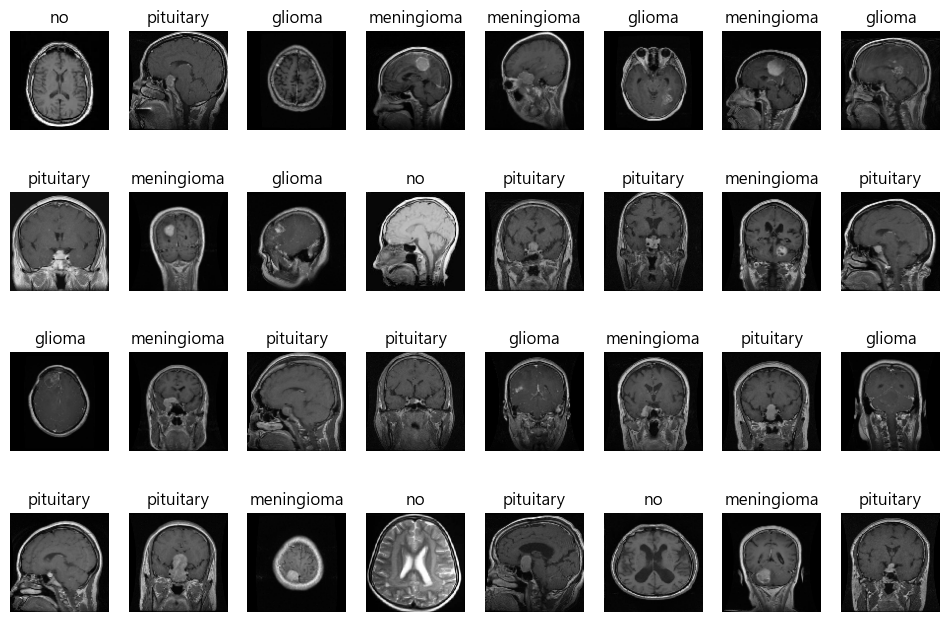

In [ ]:
img, label = train_generator.next()

plt.figure(figsize=(12, 8))

for i in range(len(img)):
    plt.subplot(4, 8, i+1)
    plt.imshow(img[i])
    plt.axis("off")
    plt.title(list(train_generator.class_indices.keys())[int(label[i])].split("_")[0])

## Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [ ]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(516, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=2e-5), metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 516)               66564     
                                                                 
 dropout_5 (Dropout)         (None, 516)              

In [ ]:
start = datetime.now()

# save_file_name = "./brain_tumor_Colab_model.h5"
# check_point = ModelCheckpoint(save_file_name, monitor="val_loss", save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

result = model.fit(train_generator, epochs=2 , validation_data=val_generator, callbacks = [early_stopping])
end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/2
72/72 [==============================] - 30s 354ms/step - loss: 1.7685 - accuracy: 0.3000 - val_loss: 1.3907 - val_accuracy: 0.2880
Epoch 2/2
72/72 [==============================] - 26s 358ms/step - loss: 1.4292 - accuracy: 0.4018 - val_loss: 1.2046 - val_accuracy: 0.4311
걸린 시간 : 0:00:56.080408


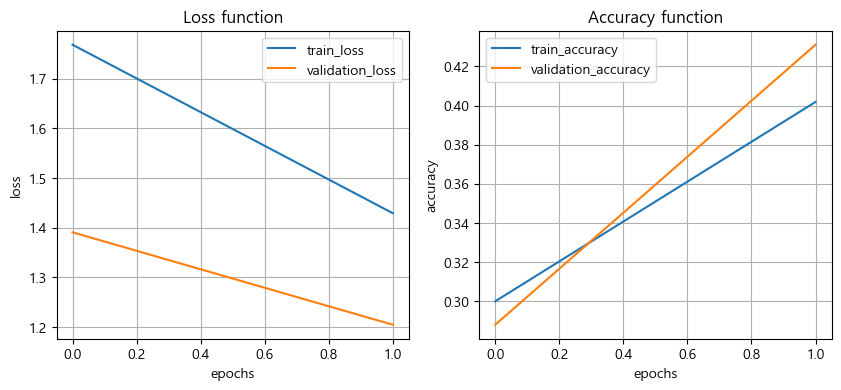

In [ ]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

In [ ]:
model.evaluate(test_generator)

13/13 [==============================] - 1s 85ms/step - loss: 1.4092 - accuracy: 0.3147


[1.4092291593551636, 0.3147208094596863]

# 2. Project-2 : MobileNet

- train과 test 데이터를 합쳐 섞은 후 재분리
- Convolution Layer추가 해보기

## 경로설정 및 정답 및 전체 데이터 수 확인

In [105]:
#### Colab ####
from google.colab import drive

ROOT_DIR = "/content/"

drive.mount("/content/gdrive")
shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab_Notebooks/data", "brain_tumor.zip"), ROOT_DIR)

DATA_ROOT_DIR = os.path.join(ROOT_DIR, "brain_tumor")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Training")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Testing")

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "brain_tumor.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_file_list)

for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  826
meningioma_tumor  =>  822
no_tumor  =>  395
pituitary_tumor  =>  827
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  100
meningioma_tumor  =>  115
no_tumor  =>  105
pituitary_tumor  =>  74


## Testing디렉토리의 모든 파일을 Training 동일 디렉토리로 MOVE

In [106]:
test_label_name = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name)

for label_name in test_label_name:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 이동시킬 데이터가 들어있는 경로
    test_file_list = os.listdir(test_path)                      # 이동시킬 데이터 담아두기

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)  # 이동된 데이터를 담을 경로

    move_num=0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num+=1
    print(str(move_num) + " is move into " + label_name + "(Testing -> Training)")

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
100 is move into glioma_tumor(Testing -> Training)
115 is move into meningioma_tumor(Testing -> Training)
105 is move into no_tumor(Testing -> Training)
74 is move into pituitary_tumor(Testing -> Training)


## move 완료된 Training 전체 데이터 수 확인

In [4]:
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_file_list)

for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  926
meningioma_tumor  =>  937
no_tumor  =>  396
pituitary_tumor  =>  901


## Shuffle 후 Testing으로 재이동

In [107]:
MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 목적 경로

    train_data_file_list = os.listdir(src)

    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)

    test_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num += 1
    print("move nums =>", move_num, "(Training -> Testing)")

total [glioma_tumor] data file nums => [926]
train data shuffle is done!
split nums => 185
move nums => 185 (Training -> Testing)
total [meningioma_tumor] data file nums => [937]
train data shuffle is done!
split nums => 187
move nums => 187 (Training -> Testing)
total [no_tumor] data file nums => [396]
train data shuffle is done!
split nums => 79
move nums => 79 (Training -> Testing)
total [pituitary_tumor] data file nums => [901]
train data shuffle is done!
split nums => 180
move nums => 180 (Training -> Testing)


In [108]:
#### 훈련 데이터 수 ####
train_file_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_file_list)

for i in range(len(train_file_list)):
    print(train_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, train_file_list[i]))))

print("========================================================================")

#### 테스트 데이터 수 ####
test_file_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_file_list)
for i in range(len(test_file_list)):
    print(test_file_list[i], " =>  ", end="")
    print(len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, test_file_list[i]))))

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  741
meningioma_tumor  =>  750
no_tumor  =>  317
pituitary_tumor  =>  721
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
glioma_tumor  =>  185
meningioma_tumor  =>  187
no_tumor  =>  79
pituitary_tumor  =>  180


## ImageDataGenerator을 이용해서 데이터 불러오기

In [109]:
IMG_WIDTH, IMG_HEIGHT = 224, 224

train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                     subset="training")
val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                 subset="validation")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

Found 2024 images belonging to 4 classes.
Found 505 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


## Fine Tunning을 위한 pre-trained 정의 및 모델 구축

In [110]:
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(516, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=2e-5), metrics=["accuracy"])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_20  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_52 (Dense)            (None, 516)               528900    
                                                                 
 dropout_26 (Dropout)        (None, 516)               0         
                                                                 
 dense_53 (Dense)            (None, 128)               66176     
                                                                 
 dropout_27 (Dropout)        (None, 128)             

In [111]:
start = datetime.now()

# save_file_name = "./brain_tumor_Colab_model.h5"
# check_point = ModelCheckpoint(save_file_name, monitor="val_loss", save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

result = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks = [early_stopping])
end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/50
64/64 [==============================] - 33s 265ms/step - loss: 1.8884 - accuracy: 0.3063 - val_loss: 1.2006 - val_accuracy: 0.3723
Epoch 2/50
64/64 [==============================] - 14s 220ms/step - loss: 1.2024 - accuracy: 0.5143 - val_loss: 1.0759 - val_accuracy: 0.4851
Epoch 3/50
64/64 [==============================] - 14s 220ms/step - loss: 0.9500 - accuracy: 0.6166 - val_loss: 0.9968 - val_accuracy: 0.5327
Epoch 4/50
64/64 [==============================] - 14s 222ms/step - loss: 0.8048 - accuracy: 0.6932 - val_loss: 0.8941 - val_accuracy: 0.6079
Epoch 5/50
64/64 [==============================] - 14s 224ms/step - loss: 0.6648 - accuracy: 0.7490 - val_loss: 0.8065 - val_accuracy: 0.6693
Epoch 6/50
64/64 [==============================] - 14s 220ms/step - loss: 0.5821 - accuracy: 0.7787 - val_loss: 0.6726 - val_accuracy: 0.7228
Epoch 7/50
64/64 [==============================] - 14s 217ms/step - loss: 0.5116 - accuracy: 0.8029 - val_loss: 0.5844 - val_accuracy: 0.7703

In [112]:
model.evaluate(test_generator)

20/20 [==============================] - 3s 144ms/step - loss: 0.2543 - accuracy: 0.9144


[0.2543337047100067, 0.914421558380127]

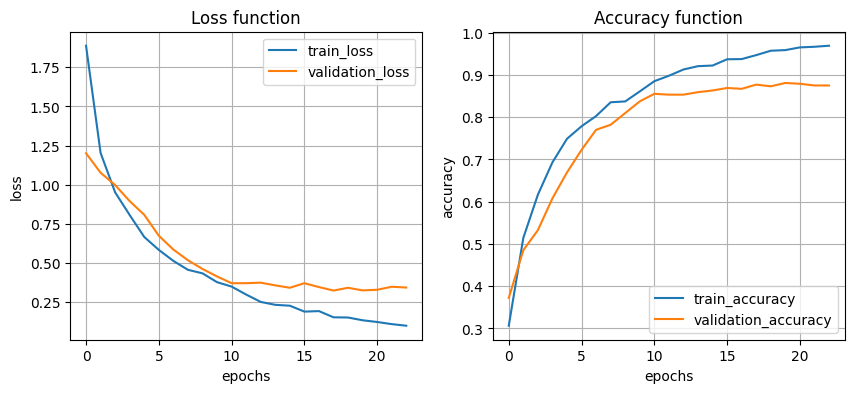

In [113]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(result.history["accuracy"], label="train_accuracy")
plt.plot(result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

# Project-3

-  Xception, ResNet50, InceptionV3, MobileNet 다양한 모델 사용하기

## 데이터셋 준비

In [114]:
#### Colab ####
from google.colab import drive

ROOT_DIR = "/content/"

drive.mount("/content/gdrive")
shutil.copy(os.path.join("/content/gdrive/MyDrive/Colab_Notebooks/data", "brain_tumor.zip"), ROOT_DIR)

DATA_ROOT_DIR = os.path.join(ROOT_DIR, "brain_tumor")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Training")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "Testing")

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "brain_tumor.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

#### Testing -> Training ####
test_label_name = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name)

for label_name in test_label_name:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 이동시킬 데이터가 들어있는 경로
    test_file_list = os.listdir(test_path)                      # 이동시킬 데이터 담아두기

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)  # 이동된 데이터를 담을 경로

    move_num=0
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file), os.path.join(train_path, test_file))
        move_num+=1
    print(str(move_num) + " is move into " + label_name + "(Testing -> Training)")

#### Shuffle -> Testing 분할 ####
MOVE_RATIO = 0.2

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)   # 출발 경로
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)    # 목적 경로

    train_data_file_list = os.listdir(src)

    print("=========================================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))

    np.random.shuffle(train_data_file_list)                  # 데이터 섞어주기
    print("train data shuffle is done!")

    split_num = int(MOVE_RATIO * len(train_data_file_list))  # 재이동시킬 데이터 수
    print("split nums =>", split_num)

    test_data_file_list = train_data_file_list[0:split_num]
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file), os.path.join(dst, test_data_file))
        move_num += 1
    print("move nums =>", move_num, "(Training -> Testing)")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
100 is move into glioma_tumor(Testing -> Training)
115 is move into meningioma_tumor(Testing -> Training)
105 is move into no_tumor(Testing -> Training)
74 is move into pituitary_tumor(Testing -> Training)
total [glioma_tumor] data file nums => [926]
train data shuffle is done!
split nums => 185
move nums => 185 (Training -> Testing)
total [meningioma_tumor] data file nums => [937]
train data shuffle is done!
split nums => 187
move nums => 187 (Training -> Testing)
total [no_tumor] data file nums => [396]
train data shuffle is done!
split nums => 79
move nums => 79 (Training -> Testing)
total [pituitary_tumor] data file nums => [901]
train data shuffle is done!
split nums => 180
move nums => 180 (Training -> Testing)


## ImageDataGenerator을 이용해서 데이터 불러오기

In [115]:
IMG_WIDTH, IMG_HEIGHT = 224 , 224

train_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                     target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                     subset="training")
val_generator = val_data_gen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                 target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse",
                                                 subset="validation")
test_generator = test_data_gen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode="rgb",
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT), class_mode="sparse")

print("===============================================================================")
print(train_generator.class_indices)
print(train_generator.num_classes)

Found 2024 images belonging to 4 classes.
Found 505 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
4


## 모델 학습

### (1) Xception

#### 모델 구축 및 학습

In [62]:
Xception_model = Xception(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(Xception_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(516, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 128)               262272    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 516)               66564     
                                                                 
 dropout_16 (Dropout)        (None, 516)               0         
                                                     

In [63]:
start = datetime.now()

# save_file_name = "./brain_tumor_Colab_model.h5"
# check_point = ModelCheckpoint(save_file_name, monitor="val_loss", save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

Xception_result = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks = [early_stopping])
end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/50
64/64 [==============================] - 75s 588ms/step - loss: 1.3856 - accuracy: 0.2762 - val_loss: 1.3512 - val_accuracy: 0.3050
Epoch 2/50
64/64 [==============================] - 35s 539ms/step - loss: 1.2998 - accuracy: 0.3770 - val_loss: 1.3103 - val_accuracy: 0.3366
Epoch 3/50
64/64 [==============================] - 34s 530ms/step - loss: 1.2103 - accuracy: 0.4684 - val_loss: 1.2571 - val_accuracy: 0.4277
Epoch 4/50
64/64 [==============================] - 35s 538ms/step - loss: 1.0854 - accuracy: 0.5815 - val_loss: 1.1901 - val_accuracy: 0.5208
Epoch 5/50
64/64 [==============================] - 34s 537ms/step - loss: 0.9449 - accuracy: 0.6462 - val_loss: 1.1024 - val_accuracy: 0.5822
Epoch 6/50
64/64 [==============================] - 35s 544ms/step - loss: 0.7952 - accuracy: 0.7357 - val_loss: 1.0129 - val_accuracy: 0.6099
Epoch 7/50
64/64 [==============================] - 34s 536ms/step - loss: 0.6740 - accuracy: 0.7653 - val_loss: 0.9280 - val_accuracy: 0.6554

In [64]:
model.evaluate(test_generator)

20/20 [==============================] - 4s 189ms/step - loss: 0.2376 - accuracy: 0.9176


[0.23763175308704376, 0.9175911545753479]

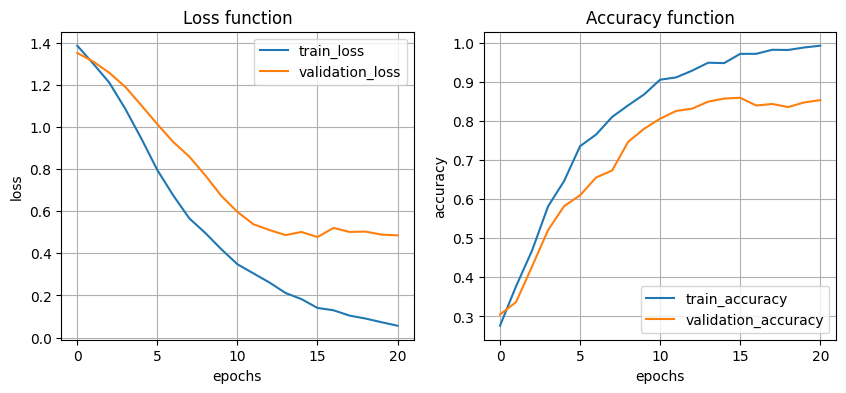

In [65]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(Xception_result.history["loss"], label="train_loss")
plt.plot(Xception_result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(Xception_result.history["accuracy"], label="train_accuracy")
plt.plot(Xception_result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

### (2) ResNet50

#### 모델 구축 및 학습

In [72]:
ResNet50_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(ResNet50_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(516, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=1e-5), metrics=["accuracy"])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_13  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 516)               66564     
                                                                 
 dropout_18 (Dropout)        (None, 516)               0         
                                                     

In [73]:
start = datetime.now()

# save_file_name = "./brain_tumor_Colab_model.h5"
# check_point = ModelCheckpoint(save_file_name, monitor="val_loss", save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

ResNet50_result = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks = [early_stopping])
end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/50
64/64 [==============================] - 83s 421ms/step - loss: 1.3033 - accuracy: 0.4042 - val_loss: 1.3913 - val_accuracy: 0.2594
Epoch 2/50
64/64 [==============================] - 25s 389ms/step - loss: 1.0323 - accuracy: 0.5736 - val_loss: 1.4161 - val_accuracy: 0.3010
Epoch 3/50
64/64 [==============================] - 26s 399ms/step - loss: 0.8413 - accuracy: 0.6749 - val_loss: 1.4278 - val_accuracy: 0.2871
Epoch 4/50
64/64 [==============================] - 24s 377ms/step - loss: 0.6850 - accuracy: 0.7406 - val_loss: 1.4270 - val_accuracy: 0.2950
Epoch 5/50
64/64 [==============================] - 24s 379ms/step - loss: 0.5627 - accuracy: 0.7935 - val_loss: 1.4166 - val_accuracy: 0.2594
Epoch 6/50
64/64 [==============================] - 25s 382ms/step - loss: 0.4594 - accuracy: 0.8449 - val_loss: 1.4207 - val_accuracy: 0.2436
Epoch 6: early stopping
걸린 시간 : 0:03:55.856906


In [74]:
model.evaluate(test_generator)

20/20 [==============================] - 4s 209ms/step - loss: 1.4220 - accuracy: 0.2377


[1.421966552734375, 0.2377179116010666]

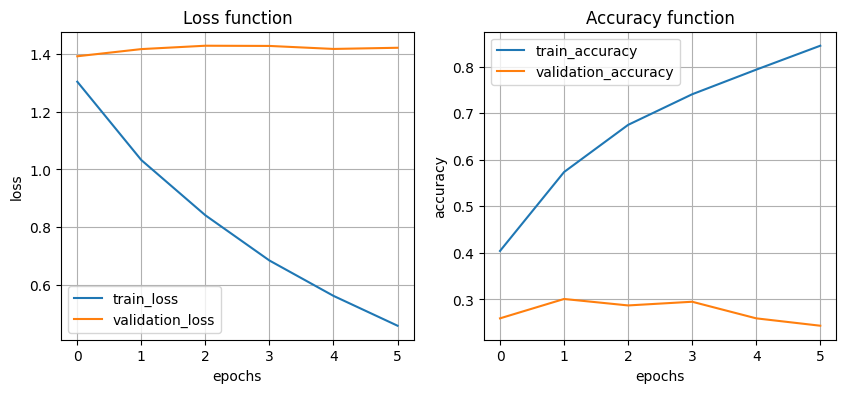

In [75]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(ResNet50_result.history["loss"], label="train_loss")
plt.plot(ResNet50_result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(ResNet50_result.history["accuracy"], label="train_accuracy")
plt.plot(ResNet50_result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")

### (3) InceptionV3

#### 모델 구축 및 학습

In [116]:
InceptionV3_model =  InceptionV3(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

model = Sequential()

model.add(InceptionV3_model)

model.add(GlobalAveragePooling2D())
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=2e-5), metrics=["accuracy"])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_21  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_55 (Dense)            (None, 256)               524544    
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_56 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 22,328,356
Trainable params: 22,293,924
Non-trainable params: 34,432
____________________________________

In [117]:
start = datetime.now()

# save_file_name = "./brain_tumor_Colab_model.h5"
# check_point = ModelCheckpoint(save_file_name, monitor="val_loss", save_best_only=True, mode="auto")
early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

InceptionV3_result = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks = [early_stopping])
end = datetime.now()

print("걸린 시간 :", end-start)

Epoch 1/50
64/64 [==============================] - 65s 311ms/step - loss: 1.0932 - accuracy: 0.5306 - val_loss: 1.0414 - val_accuracy: 0.5604
Epoch 2/50
64/64 [==============================] - 19s 289ms/step - loss: 0.5493 - accuracy: 0.8152 - val_loss: 0.7204 - val_accuracy: 0.6911
Epoch 3/50
64/64 [==============================] - 20s 308ms/step - loss: 0.3236 - accuracy: 0.8977 - val_loss: 0.6530 - val_accuracy: 0.7465
Epoch 4/50
64/64 [==============================] - 18s 288ms/step - loss: 0.1935 - accuracy: 0.9442 - val_loss: 0.6347 - val_accuracy: 0.7505
Epoch 5/50
64/64 [==============================] - 18s 284ms/step - loss: 0.1135 - accuracy: 0.9733 - val_loss: 0.6624 - val_accuracy: 0.7307
Epoch 6/50
64/64 [==============================] - 19s 301ms/step - loss: 0.0715 - accuracy: 0.9857 - val_loss: 0.6678 - val_accuracy: 0.7564
Epoch 7/50
64/64 [==============================] - 18s 285ms/step - loss: 0.0548 - accuracy: 0.9901 - val_loss: 0.6408 - val_accuracy: 0.7683

In [118]:
model.evaluate(test_generator)

20/20 [==============================] - 4s 182ms/step - loss: 0.3414 - accuracy: 0.9128


[0.3413509726524353, 0.9128367900848389]

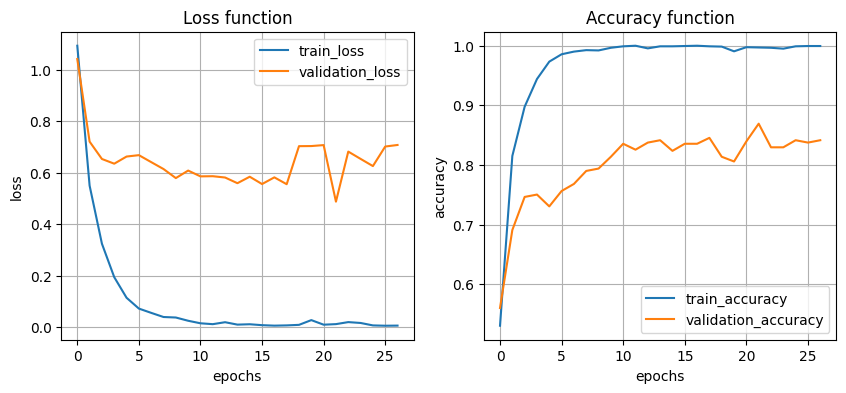

In [119]:
## 시각화 ##
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()
plt.plot(InceptionV3_result.history["loss"], label="train_loss")
plt.plot(InceptionV3_result.history["val_loss"], label="validation_loss")
plt.legend(loc="best")

plt.subplot(1, 2, 2)
plt.title("Accuracy function")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.plot(InceptionV3_result.history["accuracy"], label="train_accuracy")
plt.plot(InceptionV3_result.history["val_accuracy"], label="validation_accuracy")
plt.legend(loc="best")